In [1]:
from conditional_inference.quantile_unbiased import RQU

import math
from functools import partial
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dask import delayed
from dask.distributed import Client
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import train_test_split

n_simulations = 500
n_batches = 10
batch_size = math.ceil(n_simulations / n_batches)
n_folds = 2
param_space = dict(
    n_observations=(500,),
    n_policies=(2, 10, 20),
    best_effect=np.arange(4),
)

sns.set()
client = Client(n_workers=4)

In [2]:
def make_data(n_observations, n_policies, best_effect):
    mu = [best_effect] + [0] * (n_policies - 1)
    X = np.repeat(np.identity(n_policies), n_observations, axis=0)
    y = np.array([
        norm(loc=mu_i, scale=np.sqrt(n_observations)).rvs(n_observations) for mu_i in mu
    ]).flatten()
    groups = X.argmax(axis=1)
    return X, y, groups

X, y, groups = make_data(1000, 10, 0)

In [3]:
# repeated splitting regressor

def compute_ate(X, y):
    return (X.T @ y) / X.sum(axis=0)
    
def sum_sq_error(beta, X, y):
    return ((X @ beta - y)**2).sum()

def quantile_loss(beta, X, y, q):
    err = y - (X @ beta)
    return (err * (q - (err < 0))).sum()

loss_functions = [
    sum_sq_error,
    partial(quantile_loss, q=.25),
    partial(quantile_loss, q=.5),
    partial(quantile_loss, q=.75)
]

def compute_repeated_split_estimate(
    X, 
    y,
    groups,
    estimator=compute_ate, 
    n_samples=100,
):
    def compute_ate_train_test(X_train, X_test, y_train, y_test):
        ate_train = estimator(X_train, y_train)
        ate_test = estimator(X_test, y_test)
        order = (-ate_train).argsort()
        return ate_train[order], ate_test[order]

    def compute_estimate(loss):
        theta = minimize(
            loss,
            x0=np.zeros(ate_train.shape[1]),
            args=(ate_train, ate_test[:, 0])
        ).x
        return ate_full @ theta

    data = []
    while len(data) < n_samples:
        data.append(compute_ate_train_test(
            *train_test_split(X, y, test_size=.5, stratify=groups)
        ))
    ate_train, ate_test = zip(*data)
    ate_train, ate_test = np.array(ate_train), np.array(ate_test)
    ate_train = ate_train.mean(axis=1).reshape(-1, 1)
    ate_train = np.hstack((np.ones((ate_train.shape[0], 1)), ate_train))
    ate_full = estimator(X, y).mean().reshape(-1, 1)
    ate_full = np.insert(ate_full[(-ate_full).argsort()], 0, 1)
    return np.array([compute_estimate(loss) for loss in loss_functions])

compute_repeated_split_estimate(X, y, groups)

array([-0.94246692, -1.50663991, -0.90831131, -0.17126429])

In [4]:
# other estimators

ppf25, ppf75 = norm().ppf(.25), norm().ppf(.75)

def compute_conventional_estimate(X, y, groups):
    result = sm.OLS(y, X).fit().get_robustcov_results()
    idx = result.params.argmax()
    point, std = result.params[idx], result.cov_params()[idx, idx]
    return np.array([point, point + ppf25 * std, point, point + ppf75 * std])

def compute_hybrid_estimate(X, y, groups):
    result = sm.OLS(y, X).fit().get_robustcov_results()
    rqu = RQU.from_results(result)
    dist = rqu.get_distribution(beta=.005)
    return np.insert(dist.ppf([.25, .5, .75]), 0, np.nan)

(
    compute_conventional_estimate(X, y, groups),
    compute_hybrid_estimate(X, y, groups)
)

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(array([0.87607627, 0.17770106, 0.87607627, 1.57445148]),
 array([        nan, -2.2883276 , -0.87946546,  0.65530228]))

In [5]:
estimators = [
    ("Conventional", compute_conventional_estimate),
    ("Hybrid", compute_hybrid_estimate),
    ("RepeatedSplits", compute_repeated_split_estimate),
]

In [6]:
%%time

def run_simulation(idx, n_observations, n_policies, best_effect):
    def get_estimates(names, estimator, X, y, groups):
        estimates = estimator(X, y, groups)
        if isinstance(names, tuple):
            return [get_estimate(name, *params) for name, params in zip(names, estimates)]
        return [get_estimate(name, *estimates)]

    def get_estimate(name, mean, ppf_25, median, ppf_75):
        return dict(
            Estimator=name,
            Mean=mean,
            PPF_25=ppf_25,
            Median=median,
            PPF_75=ppf_75
        )

    X, y, groups = make_data(n_observations, n_policies, best_effect)
    data = []
    for name, estimator in estimators:
        data += get_estimates(name, estimator, X, y, groups)
    df = pd.DataFrame(data)

    df["Simulation"] = idx
    df["RecommendedEffect"] = best_effect if compute_ate(X, y).argmax() == 0 else 0
    df["NObservations"] = n_observations
    df["NPolicies"] = n_policies
    df["BestEffect"] = best_effect
    return df

def run_simulations(batch_no, params):
    simulations = range(
        batch_no * batch_size,
        min(n_simulations, (batch_no + 1) * batch_size)
    )
    return pd.concat([run_simulation(i, **params) for i in simulations])

param_grid = list(product(*param_space.values()))
param_grid = [
    {key: val for key, val in zip(param_space.keys(), config)} 
    for config in param_grid
]
results = [
    delayed(run_simulations)(batch_no, params)
    for batch_no, params in product(range(n_batches), param_grid)
]
result_df = delayed(pd.concat)(results).compute()
result_df.head()

Wall time: 32min 18s


Estimator      Mean    PPF_25    Median    PPF_75  Simulation  \
0    Conventional  0.106344 -0.630677  0.106344  0.843365           0   
1          Hybrid       NaN -1.082026 -0.121898  0.713951           0   
2  RepeatedSplits -0.459917 -0.975187 -0.184665  0.128328           0   
0    Conventional -0.247785 -0.934172 -0.247785  0.438602           1   
1          Hybrid       NaN -3.496687 -2.579087 -0.915935           1   

   RecommendedEffect  NObservations  NPolicies  BestEffect  
0                  0            500          2           0  
1                  0            500          2           0  
2                  0            500          2           0  
0                  0            500          2           0  
1                  0            500          2           0

In [7]:
result_df["Bias"] = result_df.Mean - result_df.RecommendedEffect
result_df["MedianBias"] = (result_df.Median > result_df.RecommendedEffect) - .5
result_df["PPF25Bias"] = (result_df.PPF_25 > result_df.RecommendedEffect) - .25
result_df["PPF75Bias"] = (result_df.PPF_75 > result_df.RecommendedEffect) - .75
result_df["AbsError"] = abs(result_df.Median - result_df.RecommendedEffect)
result_df["SqError"] = (result_df.Mean - result_df.RecommendedEffect)**2
result_df["InRange"] = (
    (result_df.PPF_25 < result_df.RecommendedEffect)
    & (result_df.RecommendedEffect < result_df.PPF_75)
).astype(int)
result_df["CILength"] = result_df.PPF_75 - result_df.PPF_25

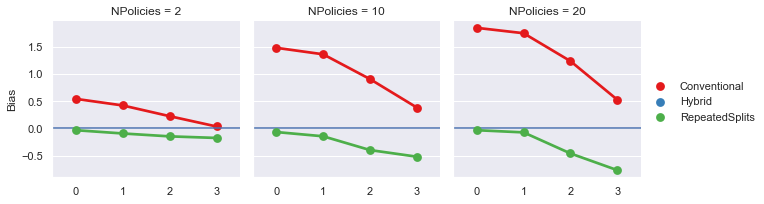

In [8]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="Bias",
    hue="Estimator",
    ci=None,
    palette="Set1"
)
[ax.axhline(0) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("Bias")

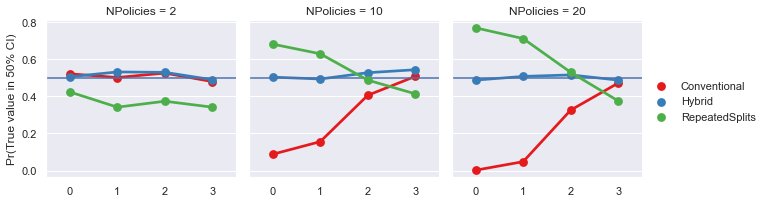

In [9]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="InRange",
    hue="Estimator",
    ci=None,
    palette="Set1"
)
[ax.axhline(.5) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("Pr(True value in 50% CI)")

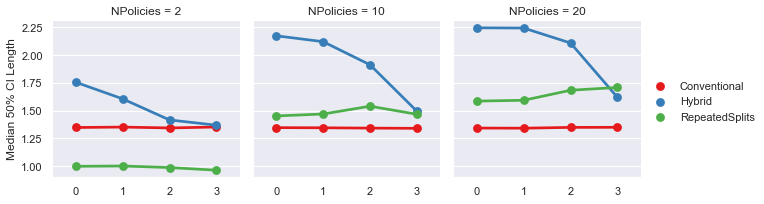

In [10]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="CILength", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .5), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("Median 50% CI Length")

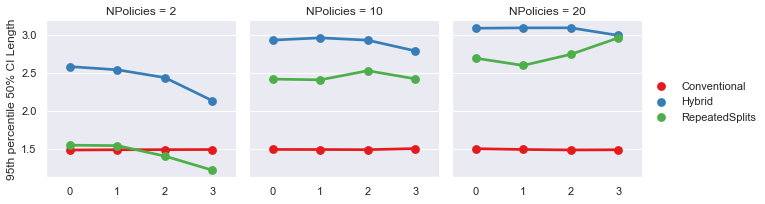

In [11]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="CILength", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .95), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("95th percentile 50% CI Length")

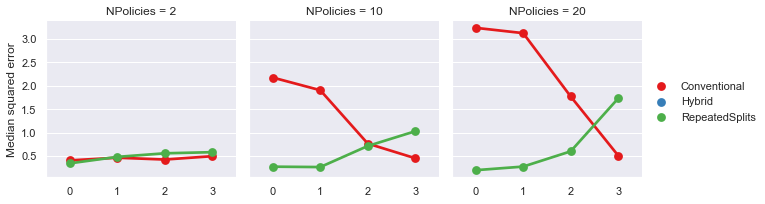

In [12]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="SqError", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .5), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("Median squared error")

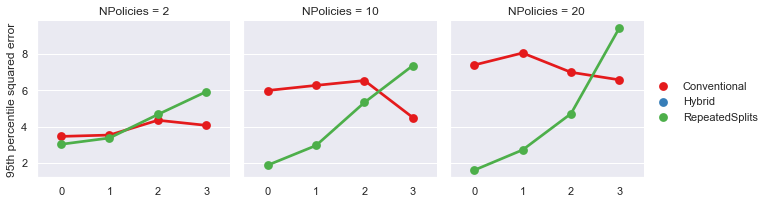

In [13]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="SqError", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .95), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("95th percentile squared error")

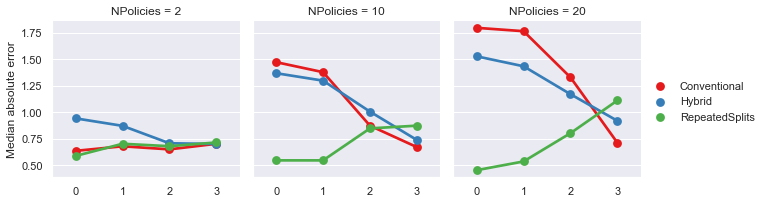

In [14]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="AbsError", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .5), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("Median absolute error")

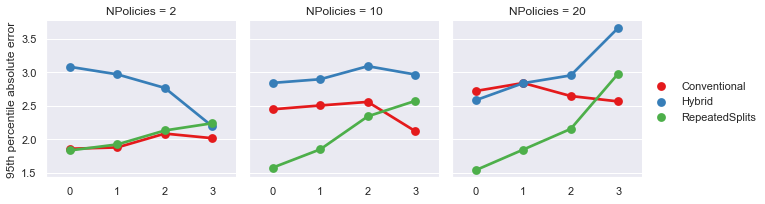

In [15]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="AbsError", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .95), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("95th percentile absolute error")

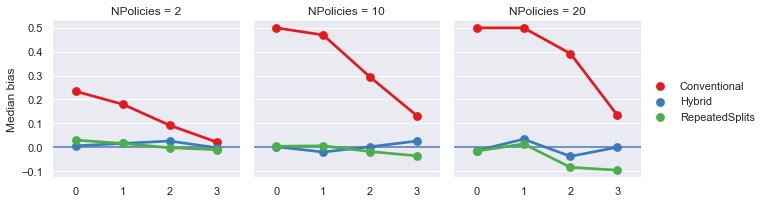

In [16]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="MedianBias", 
    hue="Estimator",
    ci=None,
    palette="Set1"
)
[ax.axhline(0) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("Median bias")

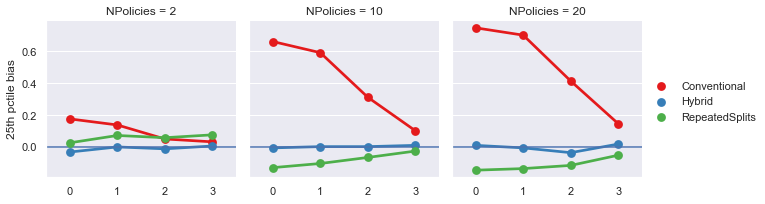

In [17]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="PPF25Bias", 
    hue="Estimator",
    ci=None,
    palette="Set1"
)
[ax.axhline(0) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("25th pctile bias")

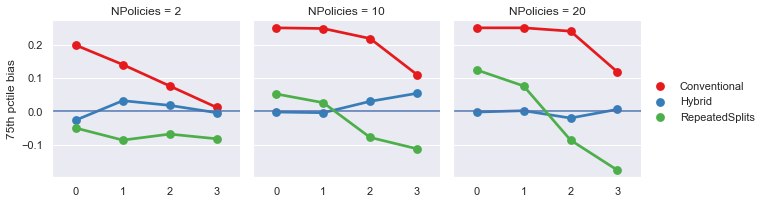

In [18]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="PPF75Bias", 
    hue="Estimator",
    ci=None,
    palette="Set1"
)
[ax.axhline(0) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("75th pctile bias")

In [19]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
